# Import

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

In [46]:
df = pd.read_csv('./s_h_p.csv')

ori_df = df

df.head()

,Name,Type,Build,Dir,minArea,maxArea,representativeArea,floorAreaRatio,minDeal,maxDeal,...,CONVENIENCE,WASHING,BANK,OFFICE,PRI_SCHOOL,PUB_SCHOOL,Old,sector,divisition,city
0,테라156,OPST,202103,EE,31.70,34.73,31.0,249,NaN,NaN,...,12,4,1,3,0,2,2021,가락동,송파구,서울시
1,아키죤,APT,200211,EE,86.83,86.83,86.0,0,89000.0,96000.0,...,20,6,12,3,0,1,2002,가락동,송파구,서울시
2,강남팰리스,OPST,202102,EE,29.23,33.19,29.0,249,30000.0,30000.0,...,34,14,13,2,0,1,2021,가락동,송파구,서울시
3,송파성원상떼빌(주상복합),APT,200606,EE,113.32,182.06,182.0,545,118000.0,200000.0,...,33,11,20,1,0,1,2006,가락동,송파구,서울시
4,가락현대TWELVE,APT,200501,EE,99.91,99.91,99.0,0,NaN,NaN,...,6,4,5,1,0,1,2005,가락동,송파구,서울시


# Select Feature & Label

In [47]:
label = 'price'
columns = ['Type', 'Dir' ,'Old', 'sector', 'divisition', 'representativeArea', 'floorAreaRatio', 'BUS', 'METRO', 'INFANT', 'PRESCHOOL', 'HOSPITAL', 'PARKING', 'MART', 'CONVENIENCE', 'BANK', 'OFFICE', 'PRI_SCHOOL', 'PUB_SCHOOL', label]


df[label] = (ori_df['minDeal'] + ori_df['maxDeal']) / 2

df = df[columns].copy()

df.dropna(inplace=True)

train_df = df

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16561 entries, 1 to 17784
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Type                16561 non-null  object 
 1   Dir                 16561 non-null  object 
 2   Old                 16561 non-null  int64  
 3   sector              16561 non-null  object 
 4   divisition          16561 non-null  object 
 5   representativeArea  16561 non-null  float64
 6   floorAreaRatio      16561 non-null  int64  
 7   BUS                 16561 non-null  int64  
 8   METRO               16561 non-null  int64  
 9   INFANT              16561 non-null  int64  
 10  PRESCHOOL           16561 non-null  int64  
 11  HOSPITAL            16561 non-null  int64  
 12  PARKING             16561 non-null  int64  
 13  MART                16561 non-null  int64  
 14  CONVENIENCE         16561 non-null  int64  
 15  BANK                16561 non-null  int64  
 16  OFFI

# Outlier

In [48]:
def remove_out(dataframe, remove_col):
    dff = dataframe
    for k in remove_col:
        level_1q = dff[k].quantile(0.25)
        level_3q = dff[k].quantile(0.75)
        IQR = level_3q - level_1q
        rev_range = 3 
        dff = dff[(dff[k] <= level_3q + (rev_range * IQR)) & (dff[k] >= level_1q - (rev_range * IQR))]
        dff = dff.reset_index(drop=True)
    return dff


train_df = remove_out(train_df, [label])

train_df[label].describe()

count     16321.000000
mean      97388.773666
std       78832.002092
min        6050.000000
25%       33250.000000
50%       80000.000000
75%      135000.000000
max      450000.000000
Name: price, dtype: float64

In [49]:
group_df = train_df.groupby(by='Type')

group_df.count()

,Dir,Old,sector,divisition,representativeArea,floorAreaRatio,BUS,METRO,INFANT,PRESCHOOL,HOSPITAL,PARKING,MART,CONVENIENCE,BANK,OFFICE,PRI_SCHOOL,PUB_SCHOOL,price
Type,,,,,,,,,,,,,,,,,,,
APT,11458,11458,11458,11458,11458,11458,11458,11458,11458,11458,11458,11458,11458,11458,11458,11458,11458,11458,11458
OPST,4863,4863,4863,4863,4863,4863,4863,4863,4863,4863,4863,4863,4863,4863,4863,4863,4863,4863,4863


## Scaler

In [50]:
from sklearn.preprocessing import MinMaxScaler as Scaler

def scale(df, col):
    scaler = Scaler()
    scaler.fit(df[[col]])
    train_data_robustScaled = scaler.transform(df[[col]])
    return pd.DataFrame(data=train_data_robustScaled, columns=[col]), scaler
    
repre_df, repre_scaler = scale(train_df, 'representativeArea')
floor_df, floor_scaler = scale(train_df, 'floorAreaRatio')

train_df['representativeArea'] = repre_df
train_df['floorAreaRatio'] = floor_df

train_df

,Type,Dir,Old,sector,divisition,representativeArea,floorAreaRatio,BUS,METRO,INFANT,PRESCHOOL,HOSPITAL,PARKING,MART,CONVENIENCE,BANK,OFFICE,PRI_SCHOOL,PUB_SCHOOL,price
0,APT,EE,2002,가락동,송파구,0.156388,0.000000,14,2,7,1,0,14,2,20,12,3,0,1,92500.0
1,OPST,EE,2021,가락동,송파구,0.030837,0.199359,17,1,13,0,1,11,4,34,13,2,0,1,30000.0
2,APT,EE,2006,가락동,송파구,0.367841,0.436349,18,3,8,1,1,14,2,33,20,1,0,1,159000.0
3,APT,EE,2018,가락동,송파구,0.209251,0.228183,9,1,9,0,0,8,1,9,9,1,0,1,306750.0
4,APT,EE,2001,가락동,송파구,0.277533,0.239392,15,1,9,1,0,7,3,24,18,1,0,2,227500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16316,OPST,SS,2013,흥인동,중구,0.061674,0.661329,15,2,6,2,2,32,5,40,23,13,0,1,16250.0
16317,APT,EN,2014,흥인동,중구,0.325991,0.557246,16,2,6,2,2,43,2,41,25,13,0,1,202500.0
16318,APT,NN,2016,흥인동,중구,0.030837,0.639712,15,2,4,1,2,48,0,38,26,12,0,1,25500.0
16319,OPST,NN,2016,흥인동,중구,0.048458,0.639712,15,2,4,1,2,48,0,38,26,12,0,1,22000.0


# Visualization

## 방향에 따른 가격

/var/folders/y8/ldvzwhm13037mvvt3p2d9n0m0000gn/T/ipykernel_5241/651298774.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


[Text(0, 20000.0, '2.00억'),
 Text(0, 40000.0, '4.00억'),
 Text(0, 60000.0, '6.00억'),
 Text(0, 80000.0, '8.00억'),
 Text(0, 100000.0, '10.00억'),
 Text(0, 120000.0, '12.00억'),
 Text(0, 140000.0, '14.00억')]

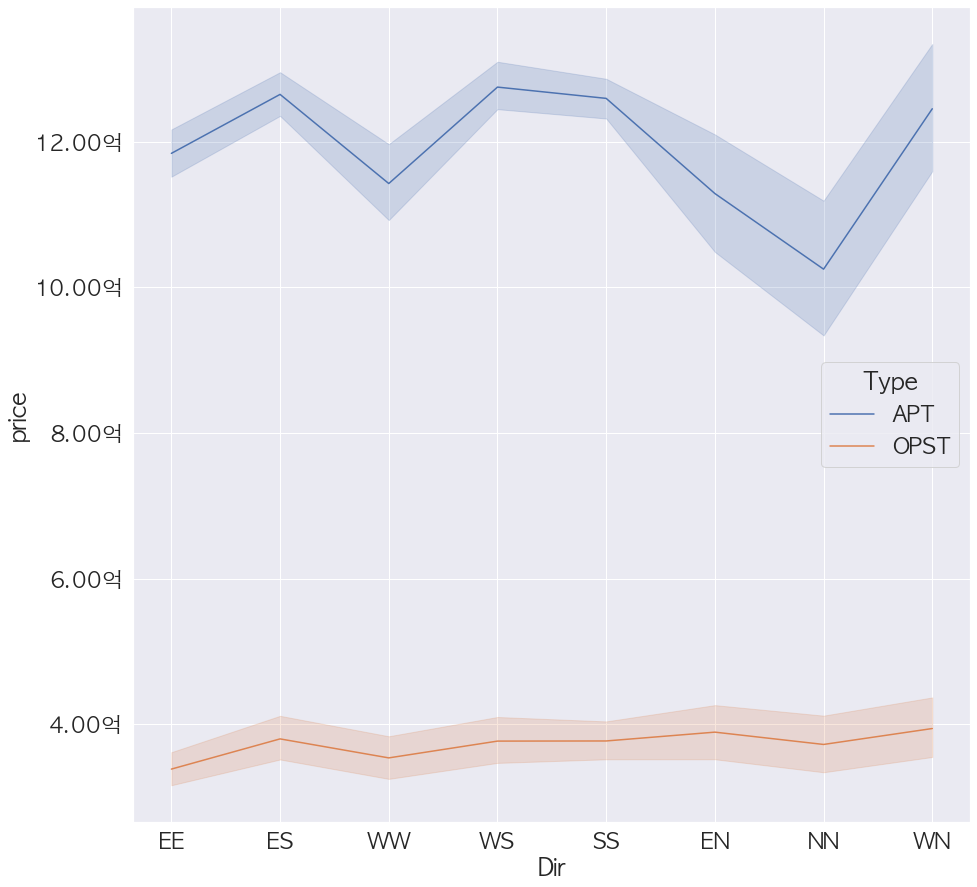

In [51]:
sns.set(rc={'figure.figsize':(15,15)})

sns.set(font_scale = 2) 
plt.rcParams['font.family'] = 'AppleGothic'
ax = sns.lineplot(x='Dir', y = label, hue='Type' , data=train_df)
ylabels = ['{:.2f}'.format(x) + '억' for x in ax.get_yticks() / 10000]
#remove '구'
# xlabels = [x for x in ax.get_xticks()]
# ax.set_xticklabels(xlabels)
ax.set_yticklabels(ylabels)

## 구에 따른 가격

/var/folders/y8/ldvzwhm13037mvvt3p2d9n0m0000gn/T/ipykernel_5241/1627207721.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


[Text(0, -50000.0, '-5억'),
 Text(0, 0.0, '0억'),
 Text(0, 50000.0, '5억'),
 Text(0, 100000.0, '10억'),
 Text(0, 150000.0, '15억'),
 Text(0, 200000.0, '20억'),
 Text(0, 250000.0, '25억')]

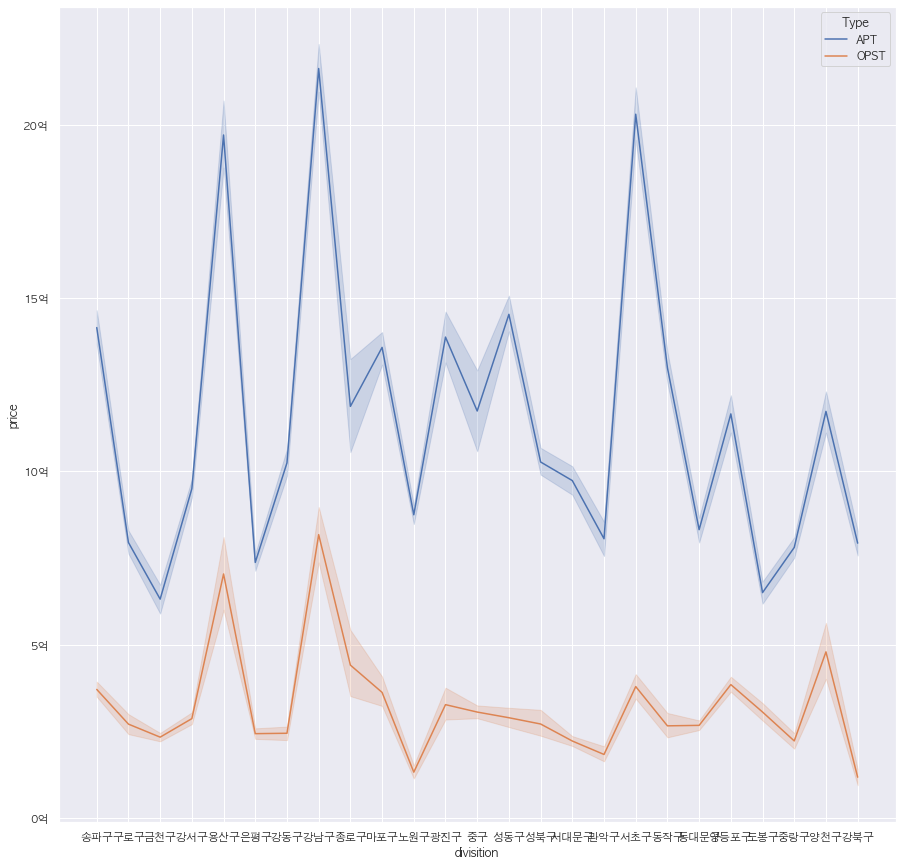

In [52]:
sns.set(font_scale = 1) 
plt.rcParams['font.family'] = 'AppleGothic'
ax = sns.lineplot(x='divisition', y = label, hue='Type' , data=train_df)
ylabels = ['{:.0f}'.format(x) + '억' for x in ax.get_yticks() / 10000]
ax.set_yticklabels(ylabels)

## 아파트 오피스텔 별 가격

/var/folders/y8/ldvzwhm13037mvvt3p2d9n0m0000gn/T/ipykernel_5241/3413037222.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


[Text(0, -100000.0, '-10억'),
 Text(0, 0.0, '0억'),
 Text(0, 100000.0, '10억'),
 Text(0, 200000.0, '20억'),
 Text(0, 300000.0, '30억'),
 Text(0, 400000.0, '40억'),
 Text(0, 500000.0, '50억')]

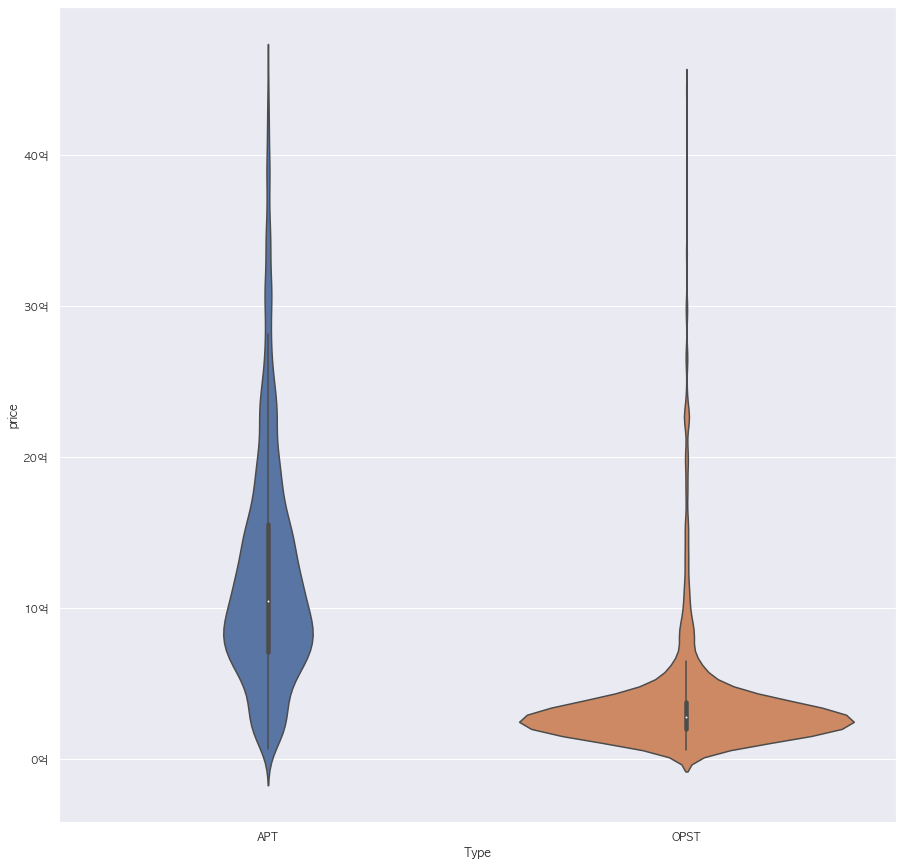

In [53]:
sns.set(font_scale = 1) 
plt.rcParams['font.family'] = 'AppleGothic'
ax = sns.violinplot(x='Type', y = label, data=train_df)
ylabels = ['{:.0f}'.format(x) + '억' for x in ax.get_yticks() / 10000]
ax.set_yticklabels(ylabels)

# Label Encoding

In [54]:
from sklearn.preprocessing import LabelEncoder

def labelencoder(df):                               
    encoders = {}
    i = 0
    for c in df.columns:     
        encoders[i] = None
        if df[c].dtype=='object': 
            df[c] = df[c].fillna('N')
            lbl = LabelEncoder()
            lbl.fit(list(df[c].values))
            df[c] = lbl.transform(df[c].values)
            encoders[i] = lbl
        i += 1
    return df, encoders

train_lbl_df, encoder_lbl = labelencoder(train_df.copy())

train_lbl_df

,Type,Dir,Old,sector,divisition,representativeArea,floorAreaRatio,BUS,METRO,INFANT,PRESCHOOL,HOSPITAL,PARKING,MART,CONVENIENCE,BANK,OFFICE,PRI_SCHOOL,PUB_SCHOOL,price
0,0,0,2002,0,17,0.156388,0.000000,14,2,7,1,0,14,2,20,12,3,0,1,92500.0
1,1,0,2021,0,17,0.030837,0.199359,17,1,13,0,1,11,4,34,13,2,0,1,30000.0
2,0,0,2006,0,17,0.367841,0.436349,18,3,8,1,1,14,2,33,20,1,0,1,159000.0
3,0,0,2018,0,17,0.209251,0.228183,9,1,9,0,0,8,1,9,9,1,0,1,306750.0
4,0,0,2001,0,17,0.277533,0.239392,15,1,9,1,0,7,3,24,18,1,0,2,227500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16316,1,4,2013,312,23,0.061674,0.661329,15,2,6,2,2,32,5,40,23,13,0,1,16250.0
16317,0,1,2014,312,23,0.325991,0.557246,16,2,6,2,2,43,2,41,25,13,0,1,202500.0
16318,0,3,2016,312,23,0.030837,0.639712,15,2,4,1,2,48,0,38,26,12,0,1,25500.0
16319,1,3,2016,312,23,0.048458,0.639712,15,2,4,1,2,48,0,38,26,12,0,1,22000.0


# One-Hot Encoding

In [55]:
from sklearn.preprocessing import OneHotEncoder

one_hot_col = ['Type', 'Dir', 'Old','sector', 'divisition']

def encode_one_hot(df, col_name):
    ohe = OneHotEncoder(sparse=False)
    trained = ohe.fit_transform(df[[col_name]].copy())
    res_df = pd.DataFrame(trained, columns=['%s_%s' % (col_name, col) for col in ohe.categories_[0]]).astype(int)
    res_df.reset_index(drop=True, inplace=True)
    return ohe, res_df
    
one_hot_df = train_df[one_hot_col]    

temp_df = train_df.drop(labels=one_hot_col, axis=1)
temp_df.reset_index(drop=True, inplace=True)

encoders_hot = []
encoded_dfs = []

for col in one_hot_col:
    ohe, p_df = encode_one_hot(one_hot_df, col)
    encoded_dfs.append(p_df)
    encoders_hot.append(ohe)
    
encoded_dfs.append(temp_df)

train_df = pd.concat(encoded_dfs, axis=1)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16321 entries, 0 to 16320
Columns: 419 entries, Type_APT to price
dtypes: float64(3), int64(416)
memory usage: 52.2 MB


In [56]:
train_df.head()

,Type_APT,Type_OPST,Dir_EE,Dir_EN,Dir_ES,Dir_NN,Dir_SS,Dir_WN,Dir_WS,Dir_WW,...,PRESCHOOL,HOSPITAL,PARKING,MART,CONVENIENCE,BANK,OFFICE,PRI_SCHOOL,PUB_SCHOOL,price
0,1,0,1,0,0,0,0,0,0,0,...,1,0,14,2,20,12,3,0,1,92500.0
1,0,1,1,0,0,0,0,0,0,0,...,0,1,11,4,34,13,2,0,1,30000.0
2,1,0,1,0,0,0,0,0,0,0,...,1,1,14,2,33,20,1,0,1,159000.0
3,1,0,1,0,0,0,0,0,0,0,...,0,0,8,1,9,9,1,0,1,306750.0
4,1,0,1,0,0,0,0,0,0,0,...,1,0,7,3,24,18,1,0,2,227500.0


In [57]:
train_df.describe()

,Type_APT,Type_OPST,Dir_EE,Dir_EN,Dir_ES,Dir_NN,Dir_SS,Dir_WN,Dir_WS,Dir_WW,...,PRESCHOOL,HOSPITAL,PARKING,MART,CONVENIENCE,BANK,OFFICE,PRI_SCHOOL,PUB_SCHOOL,price
count,16321.000000,16321.000000,16321.000000,16321.000000,16321.000000,16321.000000,16321.000000,16321.000000,16321.000000,16321.000000,...,16321.000000,16321.000000,16321.000000,16321.000000,16321.000000,16321.000000,16321.000000,16321.000000,16321.000000,16321.000000
mean,0.702040,0.297960,0.160468,0.054715,0.183812,0.048036,0.261320,0.045647,0.157037,0.088965,...,1.500705,0.591447,12.201581,1.992831,21.203480,8.060168,3.277985,0.249556,0.783163,97388.773666
std,0.457376,0.457376,0.367051,0.227430,0.387343,0.213849,0.439367,0.208724,0.363847,0.284702,...,1.274184,1.744455,13.865183,1.559486,12.115754,6.825723,2.627202,0.504305,0.734881,78832.002092
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6050.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,4.000000,1.000000,13.000000,4.000000,1.000000,0.000000,0.000000,33250.000000
50%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,8.000000,2.000000,19.000000,7.000000,3.000000,0.000000,1.000000,80000.000000
75%,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,2.000000,1.000000,16.000000,3.000000,28.000000,10.000000,4.000000,0.000000,1.000000,135000.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,8.000000,30.000000,129.000000,10.000000,80.000000,91.000000,20.000000,3.000000,4.000000,450000.000000


# To Binominal

In [58]:
binomial_header = ['BUS', 'METRO', 'INFANT', 'PRESCHOOL', 'HOSPITAL', 'PARKING', 'MART', 'CONVENIENCE', 'BANK', 'OFFICE', 'PRI_SCHOOL', 'PUB_SCHOOL']

for head in binomial_header:
    train_df.loc[:,head] = train_df[head].apply(lambda x : 1 if x > 0 else 0)

train_df


,Type_APT,Type_OPST,Dir_EE,Dir_EN,Dir_ES,Dir_NN,Dir_SS,Dir_WN,Dir_WS,Dir_WW,...,PRESCHOOL,HOSPITAL,PARKING,MART,CONVENIENCE,BANK,OFFICE,PRI_SCHOOL,PUB_SCHOOL,price
0,1,0,1,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,0,1,92500.0
1,0,1,1,0,0,0,0,0,0,0,...,0,1,1,1,1,1,1,0,1,30000.0
2,1,0,1,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,0,1,159000.0
3,1,0,1,0,0,0,0,0,0,0,...,0,0,1,1,1,1,1,0,1,306750.0
4,1,0,1,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,0,1,227500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16316,0,1,0,0,0,0,1,0,0,0,...,1,1,1,1,1,1,1,0,1,16250.0
16317,1,0,0,1,0,0,0,0,0,0,...,1,1,1,1,1,1,1,0,1,202500.0
16318,1,0,0,0,0,1,0,0,0,0,...,1,1,1,0,1,1,1,0,1,25500.0
16319,0,1,0,0,0,1,0,0,0,0,...,1,1,1,0,1,1,1,0,1,22000.0


# K-Fold

In [59]:
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

def get_rsme_score_fold(model, kf, X, y):
    X = X.values
    rsme_history = []
    for train_index, test_index in tqdm(kf.split(X)):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        rsme_history.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    return rsme_history

def get_rsme_score_random(model, X, Y, count = 5):
    rsme_history = []
    for i in range(count):
        x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)
        model.fit(x_train, y_train)
        pred = model.predict(x_test)
        rsme_history.append(np.sqrt(metrics.mean_squared_error(y_test, pred)))
    return rsme_history
    
                            
                            
X = train_df.drop(label, axis=1)
Y = train_df[label]

lbl_X = train_lbl_df.drop(label, axis=1)
lbl_Y = train_lbl_df[label]

kf = KFold(n_splits = 5, shuffle = True, random_state = 15)

X.head()

,Type_APT,Type_OPST,Dir_EE,Dir_EN,Dir_ES,Dir_NN,Dir_SS,Dir_WN,Dir_WS,Dir_WW,...,INFANT,PRESCHOOL,HOSPITAL,PARKING,MART,CONVENIENCE,BANK,OFFICE,PRI_SCHOOL,PUB_SCHOOL
0,1,0,1,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,0,1
1,0,1,1,0,0,0,0,0,0,0,...,1,0,1,1,1,1,1,1,0,1
2,1,0,1,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,0,1
3,1,0,1,0,0,0,0,0,0,0,...,1,0,0,1,1,1,1,1,0,1
4,1,0,1,0,0,0,0,0,0,0,...,1,1,0,1,1,1,1,1,0,1


## Linear - OneHot x

In [60]:
from sklearn.linear_model import LinearRegression

rmse_history = get_rsme_score_fold(LinearRegression(), kf, lbl_X, lbl_Y)

rmse_history_r = get_rsme_score_random(LinearRegression(), lbl_X, lbl_Y)

for i, v in enumerate(rmse_history):
    print(i, 'RMSE:', v, rmse_history_r[i])
print('AVG:', np.mean(rmse_history), np.mean(rmse_history_r))
print('MIN:', np.min(rmse_history), np.min(rmse_history_r))
print('MAX:', np.max(rmse_history), np.max(rmse_history_r))

0it [00:00, ?it/s]

0 RMSE: 47049.5501385541 47602.468963256375
1 RMSE: 49635.49247349249 48287.66381975599
2 RMSE: 48920.8320684698 49183.75305155174
3 RMSE: 50290.71811506801 48001.23853399174
4 RMSE: 49563.21183970679 49401.506224120014
AVG: 49091.96092705823 48495.32611853517
MIN: 47049.5501385541 47602.468963256375
MAX: 50290.71811506801 49401.506224120014


## Decision Tree

In [61]:
from sklearn.tree import DecisionTreeRegressor

rmse_history = get_rsme_score_fold(DecisionTreeRegressor(random_state = 15), kf, X, Y)

rmse_history_r = get_rsme_score_random(DecisionTreeRegressor(random_state = 15), X, Y)

for i, v in enumerate(rmse_history):
    print(i, 'RMSE:', v, rmse_history_r[i])
print('AVG:', np.mean(rmse_history), np.mean(rmse_history_r))
print('MIN:', np.min(rmse_history), np.min(rmse_history_r))
print('MAX:', np.max(rmse_history), np.max(rmse_history_r))

0it [00:00, ?it/s]

0 RMSE: 15822.093964692698 13722.87340050579
1 RMSE: 16783.73893891826 17374.500821183286
2 RMSE: 13486.522440222952 13750.78426481183
3 RMSE: 16249.279883346475 14902.05404144715
4 RMSE: 16359.911779861557 16170.338072402938
AVG: 15740.309401408387 15184.1101200702
MIN: 13486.522440222952 13722.87340050579
MAX: 16783.73893891826 17374.500821183286


## Random Forest

In [63]:
from sklearn.ensemble import RandomForestRegressor

rmse_history = get_rsme_score_fold(RandomForestRegressor(n_estimators = 30, random_state = 15), kf, X, Y)

rmse_history_r = get_rsme_score_random(RandomForestRegressor(n_estimators = 30, random_state = 15), X, Y)

for i, v in enumerate(rmse_history):
    print(i, 'RMSE:', v, rmse_history_r[i])
print('AVG:', np.mean(rmse_history), np.mean(rmse_history_r))
print('MIN:', np.min(rmse_history), np.min(rmse_history_r))
print('MAX:', np.max(rmse_history), np.max(rmse_history_r))

0it [00:00, ?it/s]

0 RMSE: 12613.106201620598 12812.183162161278
1 RMSE: 14276.675708757251 14265.655395250473
2 RMSE: 12639.414467432354 13914.323060610248
3 RMSE: 13531.32857800177 15009.719940952327
4 RMSE: 13366.839213717032 13768.991130719833
AVG: 13285.472833905802 13954.174537938834
MIN: 12613.106201620598 12812.183162161278
MAX: 14276.675708757251 15009.719940952327


## Predict

In [64]:
def encode_lbl(value, encoder, delta = 0):
    for i in range(len(value)):
        if i + delta < 0 : continue
        
        if encoder[i + delta] != None:
            value[i] = encoder[i + delta].transform([value[i]])[0]
    return value

In [66]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

model = RandomForestRegressor(n_estimators = 30, random_state = 15)

model.fit(x_train, y_train)

pred = model.predict(x_test)

print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))

RMSE: 13653.034644165044


## Important

In [68]:
pair_item = []
for i, item in enumerate(X.columns):
    pair_item.append((item, float(model.feature_importances_[i])))

pair_item = sorted(pair_item, key=lambda item: item[1], reverse=True)

for k, v in pair_item:
    print(k, "%.4f" % v)

representativeArea 0.5523
divisition_강남구 0.0862
divisition_서초구 0.0422
floorAreaRatio 0.0316
Type_APT 0.0247
Type_OPST 0.0206
divisition_용산구 0.0172
sector_여의도동 0.0108
divisition_송파구 0.0085
Old_2018 0.0076
divisition_성동구 0.0070
divisition_마포구 0.0067
sector_잠원동 0.0052
sector_한강로2가 0.0049
Old_2020 0.0046
PUB_SCHOOL 0.0043
METRO 0.0043
divisition_광진구 0.0042
sector_잠실동 0.0040
sector_청담동 0.0038
sector_한남동 0.0036
HOSPITAL 0.0035
divisition_동작구 0.0035
sector_압구정동 0.0035
PRI_SCHOOL 0.0035
Old_2021 0.0034
Old_2015 0.0032
Old_2017 0.0032
sector_논현동 0.0030
Old_2012 0.0030
sector_신정동 0.0030
Old_2006 0.0030
MART 0.0029
Old_2004 0.0028
sector_목동 0.0027
Old_2008 0.0026
Old_2014 0.0026
sector_신천동 0.0024
Old_2003 0.0024
PRESCHOOL 0.0023
OFFICE 0.0023
divisition_영등포구 0.0022
sector_대치동 0.0021
Old_2013 0.0020
sector_흑석동 0.0020
Old_2019 0.0020
Old_1987 0.0019
Old_2022 0.0019
Old_2016 0.0019
sector_이촌동 0.0017
divisition_중구 0.0017
Old_2007 0.0016
sector_자양동 0.0015
sector_개포동 0.0015
divisition_강동구 0.0015
Old_20

## Prediect

In [69]:
for item in X.columns:
    print(item)

Type_APT
Type_OPST
Dir_EE
Dir_EN
Dir_ES
Dir_NN
Dir_SS
Dir_WN
Dir_WS
Dir_WW
Old_1965
Old_1968
Old_1969
Old_1970
Old_1971
Old_1972
Old_1973
Old_1974
Old_1975
Old_1976
Old_1977
Old_1978
Old_1979
Old_1980
Old_1981
Old_1982
Old_1983
Old_1984
Old_1985
Old_1986
Old_1987
Old_1988
Old_1989
Old_1990
Old_1991
Old_1992
Old_1993
Old_1994
Old_1995
Old_1996
Old_1997
Old_1998
Old_1999
Old_2000
Old_2001
Old_2002
Old_2003
Old_2004
Old_2005
Old_2006
Old_2007
Old_2008
Old_2009
Old_2010
Old_2011
Old_2012
Old_2013
Old_2014
Old_2015
Old_2016
Old_2017
Old_2018
Old_2019
Old_2020
Old_2021
Old_2022
sector_가락동
sector_가리봉동
sector_가산동
sector_가양동
sector_갈월동
sector_갈현동
sector_강일동
sector_개봉동
sector_개포동
sector_거여동
sector_견지동
sector_경운동
sector_고덕동
sector_고척동
sector_공덕동
sector_공릉동
sector_공항동
sector_관수동
sector_관철동
sector_광장동
sector_광희동1가
sector_교북동
sector_구기동
sector_구로동
sector_구산동
sector_구수동
sector_구의동
sector_군자동
sector_궁동
sector_금호동1가
sector_금호동2가
sector_금호동3가
sector_금호동4가
sector_길동
sector_길음동
sector_낙원동
sector_남가좌동
sect

In [70]:
for item in lbl_X.columns:
    print(item)

Type
Dir
Old
sector
divisition
representativeArea
floorAreaRatio
BUS
METRO
INFANT
PRESCHOOL
HOSPITAL
PARKING
MART
CONVENIENCE
BANK
OFFICE
PRI_SCHOOL
PUB_SCHOOL


In [76]:
rep = repre_scaler.transform([[103]])[0][0]
floor = floor_scaler.transform([[237]])[0][0]

print(rep, floor)

pred_value = ['APT', 'WS', 2022, '쌍문동', '도봉구', rep, floor, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]

#금천구(시흥동, 가산동), 도봉구(쌍문동)

#마포(성산)

#강남구(개포동, 대치동), 용산(보광), 서초구(서초동)

value = []
#Label Encoder 
# value.extend(encode_lbl(pred_value, encoder_lbl))

#onehot Encoder
for i, item in enumerate(pred_value):
    if i < len(encoders_hot):
        temp = encoders_hot[i].transform([[item]])
        value.extend(temp[0].tolist())
    else:
        value.append(item)
        
price = model.predict([value])[0]

print('%d 억 %d 만원' % (int(price // 10000), int(price % 10000)))

0.19383259911894274 0.18975180144115292
9 억 6000 만원
